# *Portfolio Optimization Project Using Modern Portfolio Theory (MPT) and Markowitz Model

Goal: Constructing a moderately aggressive, risk-aware portfolio for a long-term investor seeking stable returns with exposure to growth.

Importing Required liabraries 

In [1]:

import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import time  # for handling rate limits



# Section 1: Defining Tickers and Time Range 

In [2]:
#Defining the list of tickers for my choosen asstes (EFTs+Stocks)
tickers = ["SPY", "AGG", "EFA", "MSFT", "JPM", "NVDA", "JNJ", "PG"]

In [3]:
#Setting the end date to today
end_date = datetime.today()

In [4]:
#Setting the start date to 5 years ago
start_date= end_date - timedelta(days = 5*365)
print(start_date)

2020-08-18 09:23:58.808792


In [149]:
api_key = 'OJ8Y2GIWOSA9HYQ8' 

# Initialize Alpha Vantage
ts = TimeSeries(key=api_key, output_format='pandas')


# Section 2: Downloading adjusted close price 

In [5]:
#Downnloading close price for all tickers at once
adj_close_df = pd.DataFrame()

In [6]:
!pip install pandas-datareader

In [7]:
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date,  auto_adjust=False)
    adj_close_df[ticker]=data["Adj Close"]
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
#displaying data frame
print(adj_close_df)

                   SPY         AGG        EFA        MSFT         JPM  \
Date                                                                    
2020-08-18  315.313873  103.056015  56.325871  202.625580   85.973930   
2020-08-19  314.001068  102.899490  56.075539  201.396194   86.175056   
2020-08-20  314.978668  103.082077  55.894249  206.082977   85.143211   
2020-08-21  316.096008  103.186424  55.609390  204.584763   85.099487   
2020-08-24  319.299011  103.142929  56.343132  205.228241   87.495422   
...                ...         ...        ...         ...         ...   
2025-08-11  635.919983   99.010002  89.989998  521.770020  289.559998   
2025-08-12  642.690002   99.010002  91.089996  529.239990  292.850006   
2025-08-13  644.890015   99.370003  91.639999  520.580017  290.529999   
2025-08-14  644.950012   99.089996  91.650002  522.479980  294.160004   
2025-08-15  643.440002   98.940002  92.190002  520.169983  290.489990   

                  NVDA         JNJ          PG  
D

In [9]:
# Section 3: Save Adjusted Close Prices to CSV
output_file = "adj_close_prices.csv"
adj_close_df.to_csv(output_file)

print(f"Data saved to {output_file}")

Data saved to adj_close_prices.csv


# Section 3: Calculating Lognormal Returns

In [10]:
#Calculating lognormal returns for each ticker 

price_ratio = adj_close_df / adj_close_df.shift(1)  
log_return = np.log(price_ratio)

Dropping any Mssing Values 

In [11]:
log_return=log_return.dropna()

# Section 4 : Calculate Covariance Matrix 

In [12]:
# Calculating covariance 
cov_matrix = log_return.cov()*252
print(cov_matrix)

           SPY       AGG       EFA      MSFT       JPM      NVDA       JNJ  \
SPY   0.030634  0.002006  0.023081  0.035773  0.027241  0.064104  0.007851   
AGG   0.002006  0.003660  0.002296  0.002540 -0.000950  0.003919  0.001325   
EFA   0.023081  0.002296  0.026889  0.023406  0.023427  0.044035  0.007370   
MSFT  0.035773  0.002540  0.023406  0.070410  0.020081  0.089508  0.005086   
JPM   0.027241 -0.000950  0.023427  0.020081  0.064527  0.037927  0.009822   
NVDA  0.064104  0.003919  0.044035  0.089508  0.037927  0.274146 -0.005944   
JNJ   0.007851  0.001325  0.007370  0.005086  0.009822 -0.005944  0.028814   
PG    0.010667  0.001850  0.009035  0.011438  0.007886  0.005140  0.013443   

            PG  
SPY   0.010667  
AGG   0.001850  
EFA   0.009035  
MSFT  0.011438  
JPM   0.007886  
NVDA  0.005140  
JNJ   0.013443  
PG    0.029685  


Confirming log vs. simple return differences are negligible (<0.01%)

In [13]:
# Validating Return Type Assumptions

log_means = log_return.mean()
simple_means = adj_close_df.pct_change().mean()

# Comparing differences
difference = (np.exp(log_means + 0.5*log_return.var()) - 1) - simple_means
print("Difference (%):\n", difference * 100)  # Convert to percentage

if (abs(difference) > 0.0001).any():  # If any difference > 0.01%
    print("[WARNING] Large return-type differences detected for:", 
          difference[difference > 0.0001].index.tolist())
else:
    print("Validation passed: return-type differences < 0.01%")


Difference (%):
 SPY     2.767626e-06
AGG     5.118488e-07
EFA     2.678083e-06
MSFT    1.042827e-05
JPM    -1.924475e-05
NVDA   -8.827376e-05
JNJ     6.429292e-06
PG      1.749605e-05
dtype: float64
Validation passed: return-type differences < 0.01%


# Section 5: Defining Portfolio Performance Metrics 

In [14]:
#calculating the portfolio standard deviation

def standard_deviation (weights, cov_matrix):
    """Annualized portfolio volatility (standard deviation)."""
    variance = weights.T @cov_matrix @weights
    return np.sqrt(variance)

In [15]:
#calculating the expected portfolio return
def expected_return (weights, log_return):
    """Annualized expected portfolio return."""
    return np.sum(log_return.mean()*weights)*252

In [16]:
# calculating sharpe ratio 

def sharpe_ratio(weights, log_return, cov_matrix, risk_free_rate):
    """Risk-adjusted return metric (higher = better)."""
    er = expected_return(weights, log_return)
    sd = standard_deviation(weights, cov_matrix)
    return (er - risk_free_rate) / sd

In [17]:
# Get current 10-year Treasury yield (risk-free proxy)

treasury = yf.Ticker("^TNX") #fetching 10 year US treasury yeild

risk_free_rate = treasury.history(period="1d")['Close'].iloc[-1]/100 # Convert % to decimal

print(f"Risk-Free Rate: {risk_free_rate}")

Risk-Free Rate: 0.04328000068664551


In [18]:
test_weights = np.array([1/len(tickers)] * len(tickers))
print(f"Test Sharpe Ratio: {sharpe_ratio(test_weights, log_return, cov_matrix, risk_free_rate):.2f}")

Test Sharpe Ratio: 0.80


# Section 6: Portfolio Optimization 

In [19]:
# Defining the function to mimimize (negative sharpe ratio)
def negative_sharpe_ratio(weights, log_return, cov_matrix, risk_free_rate):
    """Negative Sharpe ratio for minimization"""
    return -sharpe_ratio(weights, log_return, cov_matrix, risk_free_rate)

In [20]:
#Setting the constarint bounds for optimization

# RULE 1: Weights must sum to 100% (no leftover cash)

constraints = [ # Sum of weights = 100% (fully invested)
               {'type':'eq','fun': lambda weights: np.sum(weights)-1},

               # Tech sector (NVDA + MSFT) < 30% of portfolio
               {'type': 'ineq', 'fun': lambda weights: 0.3 - (weights[tickers.index("NVDA")] + weights[tickers.index("MSFT")])}
]


# Bounds: No asset <5% or >20% (diversification rule)
bounds = [(0.05, 0.20) for _ in range(len(tickers))]


In [21]:
#setting initial weights 

initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


In [22]:

print("Individual weights:", initial_weights)  # Should show [0.125, 0.125, ...] for 8 tickers
print("Sum of weights:", np.sum(initial_weights))  # Must be 1.0

Individual weights: [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
Sum of weights: 1.0


Comparing to Benchmarks 

In [23]:
#Calculating equal-weighted performance for comparison

equal_weights = np.array([1/len(tickers)]*len(tickers))
equal_return = expected_return(equal_weights, log_return)
equal_vol = standard_deviation(equal_weights, cov_matrix)
equal_sharpe = sharpe_ratio(equal_weights, log_return, cov_matrix, risk_free_rate)

In [24]:
#Optimize the weight to maximise Sharpe Ratio
optimized_results=minimize(negative_sharpe_ratio,initial_weights, args= (log_return,cov_matrix,risk_free_rate),method='SLSQP',constraints=constraints,bounds=bounds)

In [25]:
#Getting Optimial weights 
optimal_weights = optimized_results.x

# Section 7: Analyze the optimal Portfolio 

In [26]:
# Print optimal weights
print('optimal_weights:')
for ticker,weight in zip(tickers,optimal_weights):
    print(f'{ticker}:{weight: .2%}')

print()
optimal_portfolio_return= expected_return(optimal_weights,log_return)
optimal_portfolio_volatility= standard_deviation(optimal_weights,cov_matrix)
optimal_sharpe_ratio= sharpe_ratio(optimal_weights,log_return,cov_matrix,risk_free_rate)

print(f"Expected Annual Return : {optimal_portfolio_return: .4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility: .4f}")
print(f"Sharpe Ratio : {optimal_sharpe_ratio: .4f}")

optimal_weights:
SPY: 10.73%
AGG: 5.00%
EFA: 5.00%
MSFT: 10.00%
JPM: 20.00%
NVDA: 20.00%
JNJ: 20.00%
PG: 9.27%

Expected Annual Return :  0.2129
Expected Volatility:  0.1808
Sharpe Ratio :  0.9381


# Section 7:  Visualization 

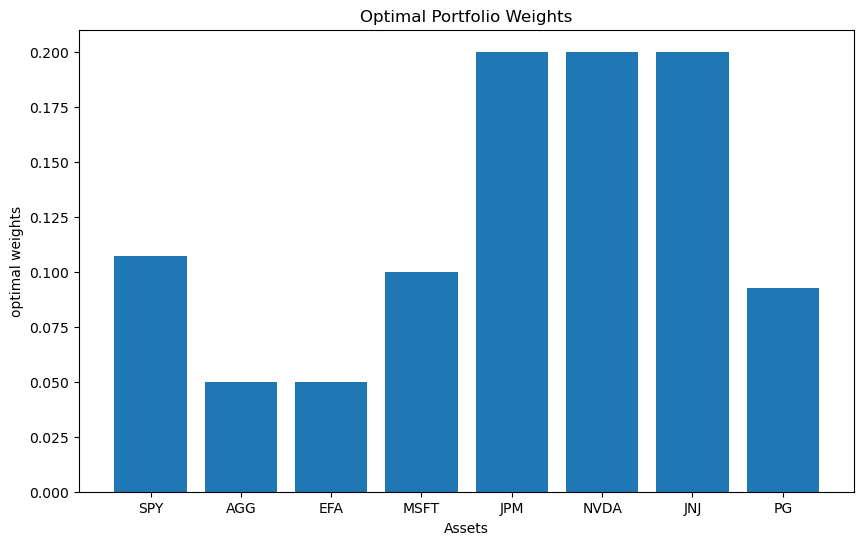

In [27]:
#Displaying the final portfolio graphically 


#importing required liabrary
import matplotlib.pyplot as plt 

#creating a vbar chart of optimal weights 
plt.figure(figsize=(10,6))
plt.bar(tickers,optimal_weights)

#Add labels and a title 
plt.xlabel('Assets')
plt.ylabel('optimal weights')
plt.title("Optimal Portfolio Weights")

#Display 
plt.show()

 


#Section 8: Efficient Frontier 

In [ ]:
#Calculate Portfolio Volatility (Risk)

def portfolio_volatility (cov_matrix, weights):
     """
    Calculates the annualized portfolio volatility (standard deviation).
    """
variance = weights.T @ cov_matrix @ weights  # Matrix multiplication: w^T * Σ * w
return np.sqrt(variance)  # Convert variance to standard deviation